### **Problem statement:**

#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [11]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [12]:
data_dir = "data/"

In [55]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(data_dir+"Train_original/")
data_dir_test = pathlib.Path(data_dir+'Test_original/')

### Importing Skin Cancer Data

In [56]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


- The dataset consists of 2357 images of malignant and benign oncological diseases

In [57]:
# Defining the parameters
batch_size = 32
epochs = 20
img_height = 180
img_width = 180

In [58]:
# To resize images to 180 x 180 in train test folders
def copy_and_resize_images(source_dir, destination_dir, img_height, img_width):
    for category in os.listdir(source_dir):
        source_folder = os.path.join(source_dir, category)
        destination_folder = os.path.join(destination_dir, category)
        os.makedirs(destination_folder, exist_ok=True)
        for image in os.listdir(source_folder):
            image_path = os.path.join(source_folder, image)
            img = PIL.Image.open(image_path)
            img = img.resize((img_height, img_width))
            new_image_path = os.path.join(destination_folder, image)
            img.save(new_image_path)

copy_and_resize_images(data_dir_train, data_dir + "Train", img_height, img_width)

copy_and_resize_images(data_dir_test, data_dir + "Test", img_height, img_width)

In [59]:
data_dir_train = pathlib.Path(data_dir+"Train/")
data_dir_test = pathlib.Path(data_dir+'Test/')

#### Creating datasets from image directories

In [62]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [63]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [64]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data

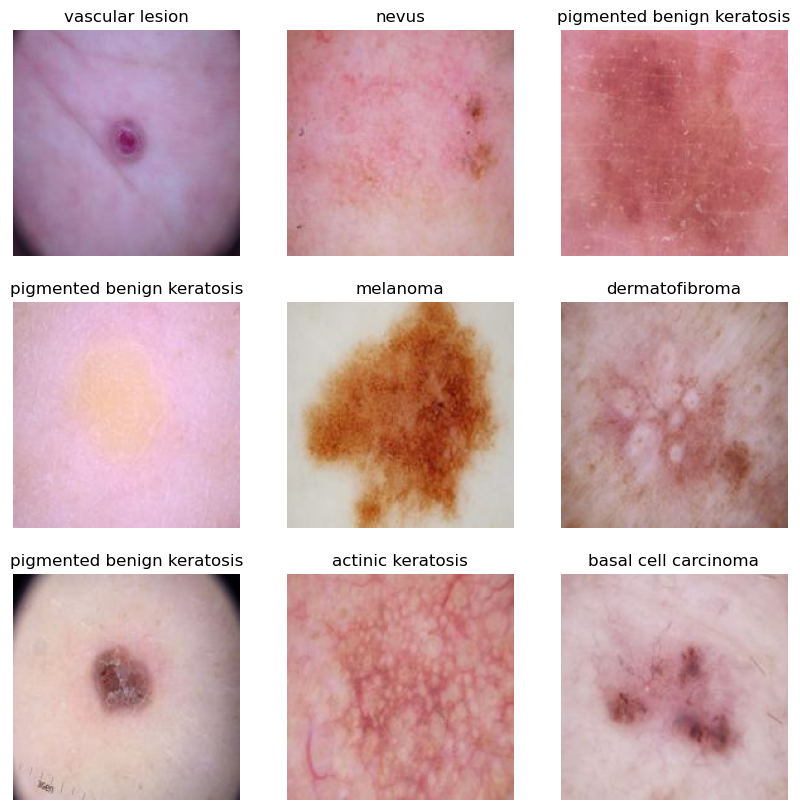

In [65]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [66]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Checking distribution of classes in the data

C:\Users\sriva\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


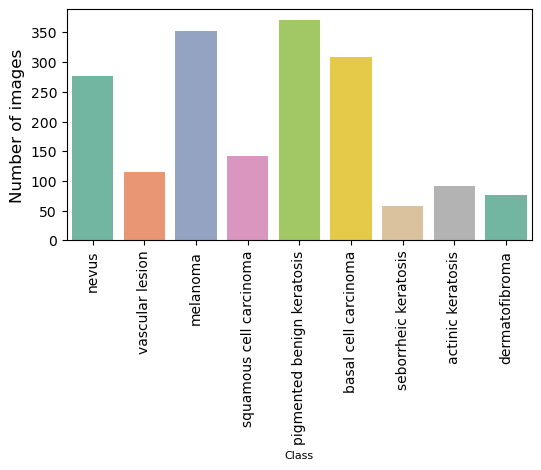

In [67]:
class_counts = {}
for images, labels in train_ds:
  for label in labels:
    class_name = class_names[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

plt.figure(figsize=(6, 3))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='Set2')
plt.xlabel('Class', fontsize=8)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=90)
plt.show()


- Data is not distributed evenly. Some classes has a lot more images than other. 
- We will first make a model with data as is.
- We will try class rebalance later if required.

#### Configure the dataset for performance

In [68]:
# overlaping data preprocessing and model execution while training to bost training speed
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating a model

- This Keras Sequential model consists of 3 Convolutional layers , 3 Max pooling layers and 1 Dense layer
- Rescaling images to normalize pixel values between (0,1).

In [69]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

- Optimizer: adam
- Loss Function: SparseCategoricalCrossentropy

In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

#### Training the model

- Training the model for 20 epochs

In [73]:
history = model.fit(train_ds,
              epochs=epochs,
              validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 21s 337ms/step - loss: 2.0194 - accuracy: 0.2266 - val_loss: 1.8645 - val_accuracy: 0.2528
Epoch 2/20
56/56 [==============================] - 17s 310ms/step - loss: 1.7440 - accuracy: 0.3728 - val_loss: 1.6259 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 15s 273ms/step - loss: 1.5112 - accuracy: 0.4704 - val_loss: 1.4596 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 15s 275ms/step - loss: 1.4970 - accuracy: 0.4927 - val_loss: 1.4090 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 15s 274ms/step - loss: 1.2933 - accuracy: 0.5385 - val_loss: 1.4909 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 15s 275ms/step - loss: 1.2454 - accuracy: 0.5597 - val_loss: 1.4481 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 15s 272ms/step - loss: 1.1478 - accuracy: 0.5904 - val_loss: 1.3335 - val_accuracy: 0.5369

#### Visualizing the results

In [74]:
def CompareAccuracyLoss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

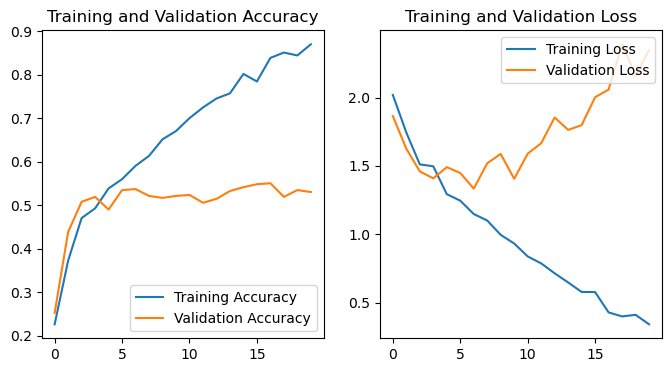

In [75]:
CompareAccuracyLoss(history)

- Here accuracy is increasing for training but flattened after 50% for validation, whereas loss is increasing for validation and decreasing for train. The difference between train and validation is hugh. This is a clear sign of overfitting

### Model with dropout and batchnormalization

- Here we have 3 Convolutional layers , 3 Max pooling layers, 2 Dropout layers and 1 Dense layer

In [81]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [82]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Training the model

In [83]:
history = model.fit(train_ds,
              epochs=epochs,
              validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 28s 454ms/step - loss: 3.7822 - accuracy: 0.3337 - val_loss: 5.9336 - val_accuracy: 0.2013
Epoch 2/20
56/56 [==============================] - 24s 427ms/step - loss: 1.5505 - accuracy: 0.4693 - val_loss: 10.1217 - val_accuracy: 0.0582
Epoch 3/20
56/56 [==============================] - 23s 409ms/step - loss: 1.3341 - accuracy: 0.5307 - val_loss: 11.6049 - val_accuracy: 0.0671
Epoch 4/20
56/56 [==============================] - 22s 392ms/step - loss: 1.2250 - accuracy: 0.5725 - val_loss: 8.0458 - val_accuracy: 0.1790
Epoch 5/20
56/56 [==============================] - 22s 389ms/step - loss: 1.1452 - accuracy: 0.5831 - val_loss: 8.2037 - val_accuracy: 0.2371
Epoch 6/20
56/56 [==============================] - 22s 396ms/step - loss: 1.0496 - accuracy: 0.6166 - val_loss: 4.7509 - val_accuracy: 0.3445
Epoch 7/20
56/56 [==============================] - 22s 395ms/step - loss: 0.9850 - accuracy: 0.6295 - val_loss: 3.9895 - val_accuracy: 0.31

#### Visualizing the results

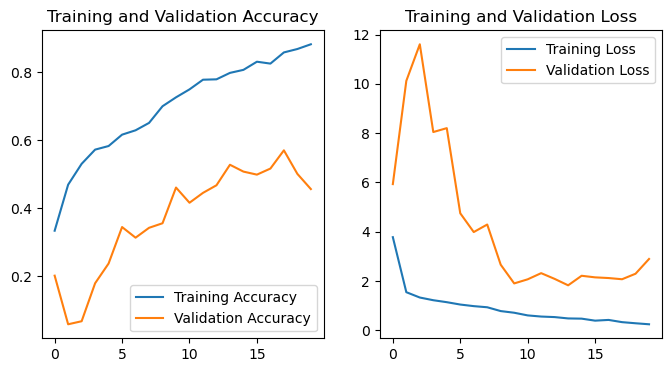

In [84]:
CompareAccuracyLoss(history)

- Still overfitting. The difference in train and test is hugh.

### Augmentation

In [86]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

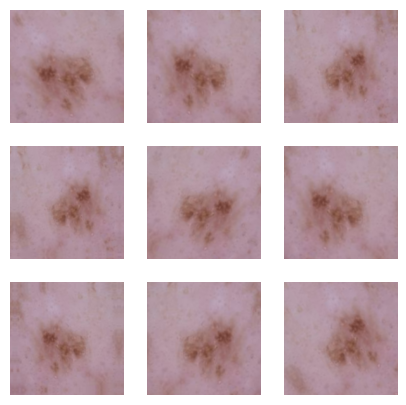

In [87]:
# Visualizing augmented image
plt.figure(figsize=(5, 5))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### Installing Augmentor to create more image for class rebalance

In [88]:
!pip install Augmentor

In [89]:
import Augmentor

#### Adding 500 samples per class

In [92]:
path_to_training_dataset=data_dir+"Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to data/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x26E0B0CEA50>: 100%|█| 500/500 [00:01<00:


Initialised with 376 image(s) found.
Output directory set to data/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x26E0B096A50>: 100%|█| 500/500 [00:01<00:00, 358.45 Samples


Initialised with 95 image(s) found.
Output directory set to data/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x26E0B04F510>: 100%|█| 500/500 [00:01<00:


Initialised with 438 image(s) found.
Output directory set to data/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x26E0AB5C290>: 100%|█| 500/500 [00:01<00:00, 449.55 Samples


Initialised with 357 image(s) found.
Output directory set to data/Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x26E0B130D10>: 100%|█| 500/500 [00:01<00:


Initialised with 462 image(s) found.
Output directory set to data/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x26E0B1334D0>: 100%|█| 500/500 [00:01<00:00, 430.01 Samples


Initialised with 77 image(s) found.
Output directory set to data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x26E0AB5EF10>: 100%|█| 500/500 [00:01<00:00, 462.17 Samples


Initialised with 181 image(s) found.
Output directory set to data/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=180x180 at 0x26E0B0EF950>: 100%|█| 500/500 [00:01<00:


Initialised with 139 image(s) found.
Output directory set to data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x26E49E46FD0>: 100%|█| 500/500 [00:01<00:00, 409.55 Samples


In [93]:
# Checking the number of new images added
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [95]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [96]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


- Total 6739 images are now available for model building and testing

#### Distribution after adding the Augmented data

C:\Users\sriva\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


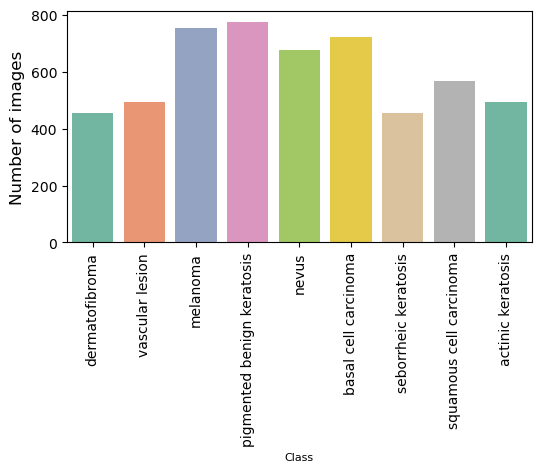

In [97]:
class_counts = {}
for images, labels in train_ds:
  for label in labels:
    class_name = class_names[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

plt.figure(figsize=(6, 3))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='Set2')
plt.xlabel('Class', fontsize=8)
plt.ylabel('Number of images', fontsize=12)
plt.xticks(rotation=90)
plt.show()

- Data is distributed much more evenly than before.
- We have handeled class imbalnce by adding augmented images to the existing classes.

### Creating model after augmentation

In [98]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [99]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [100]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

#### Training the model

In [102]:
history = model.fit(train_ds,
              epochs=epochs,
              validation_data=val_ds)

Epoch 1/20
169/169 [==============================] - 56s 305ms/step - loss: 1.9667 - accuracy: 0.2326 - val_loss: 1.6125 - val_accuracy: 0.3875
Epoch 2/20
169/169 [==============================] - 51s 301ms/step - loss: 1.5669 - accuracy: 0.3963 - val_loss: 1.5661 - val_accuracy: 0.4150
Epoch 3/20
169/169 [==============================] - 51s 302ms/step - loss: 1.4345 - accuracy: 0.4471 - val_loss: 1.3608 - val_accuracy: 0.4736
Epoch 4/20
169/169 [==============================] - 53s 314ms/step - loss: 1.3256 - accuracy: 0.4850 - val_loss: 1.2608 - val_accuracy: 0.5204
Epoch 5/20
169/169 [==============================] - 53s 311ms/step - loss: 1.2920 - accuracy: 0.5011 - val_loss: 1.1957 - val_accuracy: 0.5620
Epoch 6/20
169/169 [==============================] - 52s 311ms/step - loss: 1.2288 - accuracy: 0.5217 - val_loss: 1.1636 - val_accuracy: 0.5598
Epoch 7/20
169/169 [==============================] - 53s 311ms/step - loss: 1.2111 - accuracy: 0.5312 - val_loss: 1.1458 - val_ac

#### Visualizing the results

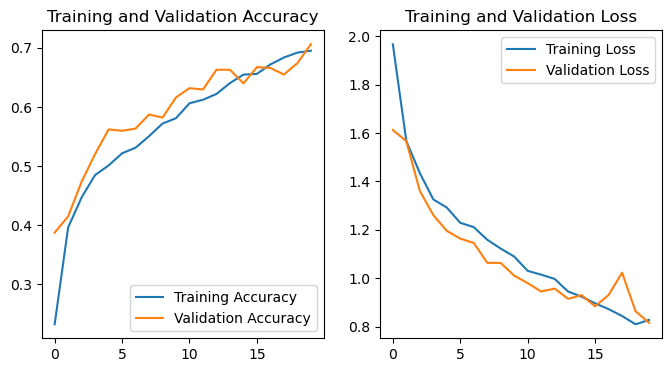

In [103]:
CompareAccuracyLoss(history)

- Train and Validation accuracy are very simmilar now. We have successfuly resolved overfitting with image augmentation & class rebalance. 
- Validation accuracy have reached 70%. Lets see if we can improve it further.

### Creating model after augmentation with 4 conv layers, 4 max pool layers, 4 normalization layers & 1 dropout layer. Running for 30 epochs

In [105]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_12 (Ba  (None, 180, 180, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)       

#### Training the model

In [108]:
epochs=30

In [109]:
history = model.fit(train_ds,
              epochs=epochs,
              validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 83s 471ms/step - loss: 2.0460 - accuracy: 0.3715 - val_loss: 17.0103 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 77s 457ms/step - loss: 1.4189 - accuracy: 0.4560 - val_loss: 7.9980 - val_accuracy: 0.1463
Epoch 3/30
169/169 [==============================] - 78s 462ms/step - loss: 1.3259 - accuracy: 0.4835 - val_loss: 3.2302 - val_accuracy: 0.3445
Epoch 4/30
169/169 [==============================] - 78s 461ms/step - loss: 1.2445 - accuracy: 0.5210 - val_loss: 1.2739 - val_accuracy: 0.5167
Epoch 5/30
169/169 [==============================] - 77s 453ms/step - loss: 1.1692 - accuracy: 0.5566 - val_loss: 1.9855 - val_accuracy: 0.3950
Epoch 6/30
169/169 [==============================] - 76s 452ms/step - loss: 1.1032 - accuracy: 0.5784 - val_loss: 1.2115 - val_accuracy: 0.5546
Epoch 7/30
169/169 [==============================] - 77s 459ms/step - loss: 1.0416 - accuracy: 0.5996 - val_loss: 1.2245 - val_a

#### Visualizing the results

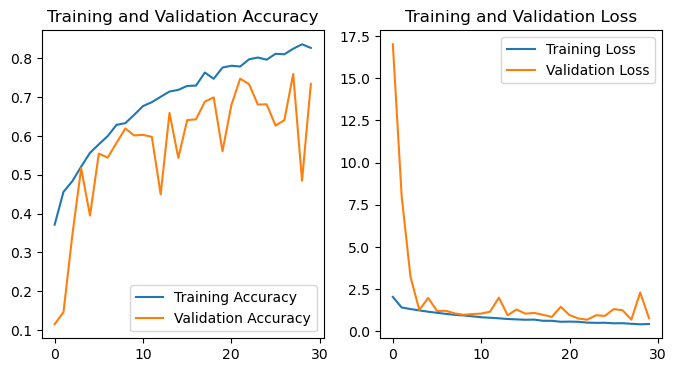

In [111]:
CompareAccuracyLoss(history)

- The difference between training and validation is not to big and is in acceptable range.
- There are fluctuations in the validation accuracy and loss. However, after 30 epochs validation accuracy has reached about ~74%
- This is a slight improvement from our previous model

### Creating model with augmentation with 4 conv layers, 4 max pool layers, 2 dropout layers. Running for 30 epochs

In [116]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [117]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [118]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

#### Training the model

In [119]:
history = model.fit(train_ds,
              epochs=epochs,
              validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 61s 342ms/step - loss: 1.9472 - accuracy: 0.2480 - val_loss: 1.7680 - val_accuracy: 0.3422
Epoch 2/30
169/169 [==============================] - 59s 350ms/step - loss: 1.6203 - accuracy: 0.3754 - val_loss: 1.4986 - val_accuracy: 0.4269
Epoch 3/30
169/169 [==============================] - 59s 350ms/step - loss: 1.4941 - accuracy: 0.4175 - val_loss: 1.4740 - val_accuracy: 0.4491
Epoch 4/30
169/169 [==============================] - 61s 364ms/step - loss: 1.4347 - accuracy: 0.4410 - val_loss: 1.3395 - val_accuracy: 0.4811
Epoch 5/30
169/169 [==============================] - 59s 349ms/step - loss: 1.3448 - accuracy: 0.4861 - val_loss: 1.3574 - val_accuracy: 0.4722
Epoch 6/30
169/169 [==============================] - 57s 340ms/step - loss: 1.2930 - accuracy: 0.4944 - val_loss: 1.2954 - val_accuracy: 0.4929
Epoch 7/30
169/169 [==============================] - 56s 330ms/step - loss: 1.2428 - accuracy: 0.5198 - val_loss: 1.1937 - val_ac

#### Visualizing the results

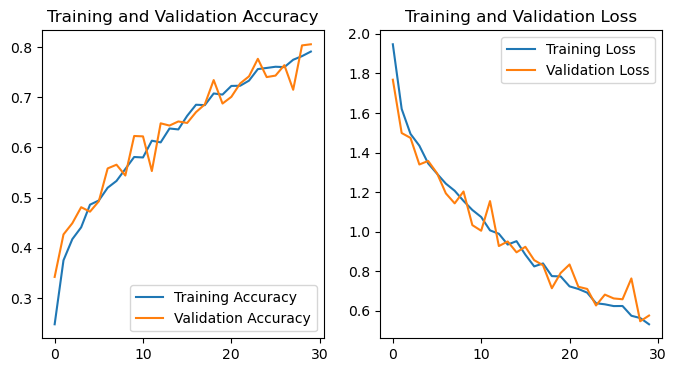

In [120]:
CompareAccuracyLoss(history)

- The training and validation are going neck to neck. There is no overfitting.
- After 30 epochs validation accuracy has reached about 80%
- This is our best model so far.